# D7059E

*   Jacob Yousif
*   Donato Scarano


## Importing libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%%capture
!pip install pytorch-tabnet matplotlib seaborn

In [3]:
%%capture

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import seaborn as sns
from itertools import cycle
from sklearn.metrics import multilabel_confusion_matrix

## Data Loading

In [4]:
file_path = 'datasets/Vectorized15SentenceSegments.csv'
df = pd.read_csv(file_path)
main = df.copy()

In [5]:
plots_dir = 'a/4/'

In [6]:
filtered_df = df[df['AuthorCode'].isin([2, 4, 8, 13])]
df = filtered_df.copy()
df.loc[df['AuthorCode'] == 2, 'AuthorCode'] = 0
df.loc[df['AuthorCode'] == 4, 'AuthorCode'] = 1
df.loc[df['AuthorCode'] == 8, 'AuthorCode'] = 2
df.loc[df['AuthorCode'] == 13, 'AuthorCode'] = 3
df = df.dropna().reset_index(drop=True)

In [7]:
df

,Book,Author,Genre,Publish-Year,Average-Rating,AuthorCode,AverageWordLength,AverageSentenceLengthByWord,AverageSyllablePerWord,SpecialCharactersCount,...,ShannonEntropy,FleschReadingEase,FleschKincaidGradeLevel,DaleChallReadability,GunningFog,AverageSentenceLengthByChar,Sentiment,Text,Pre-Text,Lemmatized-Text
0,The Mill On The Floss,George Eliot,Realist Novel,1860,3.82,1,5.991304,28.466667,1.673913,0.004950,...,4.154950,65.90,11.6,26.306113,13.42,160.666667,0.077391,"Chapter I. Outside Dorlcote Mill A wide plain,...",chapter outside dorlcote mill wide plain broad...,chapter outside dorlcote mill wide plain broad...
1,The Mill On The Floss,George Eliot,Realist Novel,1860,3.82,1,5.792627,30.533333,1.577982,0.001611,...,4.092229,65.90,11.6,26.509303,13.34,164.600000,0.117253,And this is Dorlcote Mill. I must stand a minu...,dorlcote mill must stand minute two bridge loo...,dorlcote mill must stand minute two bridge loo...
2,The Mill On The Floss,George Eliot,Realist Novel,1860,3.82,1,5.315271,27.733333,1.587379,0.002301,...,4.197152,77.20,9.4,25.397550,12.04,143.933333,0.165984,Look at their grand shaggy feet that seem to g...,look grand shaggy feet seem grasp firm earth p...,look grand shaggy foot seem grasp firm earth p...
3,The Mill On The Floss,George Eliot,Realist Novel,1860,3.82,1,4.457627,26.733333,1.493927,0.008798,...,4.295695,71.38,9.5,24.761840,11.44,135.466667,0.163482,"Chapter II. Mr Tulliver, of Dorlcote Mill, Dec...",chapter ii mr tulliver dorlcote mill declares ...,chapter ii mr tulliver dorlcote mill declare r...
4,The Mill On The Floss,George Eliot,Realist Novel,1860,3.82,1,4.090566,28.133333,1.418519,0.006007,...,4.308364,82.78,7.2,25.253241,9.73,143.333333,0.204491,_He’s_ none frightened at him.” Mr Tulliver wa...,hes none frightened mr tulliver speaking wife ...,he none frighten mr tulliver speak wife blond ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13380,Nostromo,Joseph Conrad,Political Fiction,1904,3.81,0,6.095238,12.400000,1.791304,0.004596,...,4.200961,72.66,7.0,22.060751,9.00,71.600000,-0.000303,"""The child had to be protected,"" he said, in a...",child protected said strange mournful voice be...,child protect say strange mournful voice behin...
13381,Nostromo,Joseph Conrad,Political Fiction,1904,3.81,0,5.841270,14.400000,1.707692,0.001625,...,4.186084,81.22,5.8,22.379534,8.57,81.133333,-0.006167,He put them on. After a long period of immobil...,put long period immobility opened book high lo...,put long period immobility open book high look...
13382,Nostromo,Joseph Conrad,Political Fiction,1904,3.81,0,5.580000,7.066667,1.406250,0.000000,...,4.151128,87.11,3.5,20.407803,4.59,37.733333,-0.062821,"""Linda!"" he shouted, throwing back his head. ""...",linda shouted throwing back head linda linda s...,linda shout throw back head linda linda stand ...
13383,Nostromo,Joseph Conrad,Political Fiction,1904,3.81,0,6.010101,12.466667,1.794393,0.000934,...,4.200705,69.41,8.2,21.794238,9.83,70.466667,0.197743,Linda's black figure detached itself upright o...,lindas black figure detached upright light lan...,lindas black figure detach upright light lante...


In [8]:
print('The length of the dataset is:', str(len(df)))

The length of the dataset is: 13385


In [9]:
has_nan = df.isnull().values.any()
print(f"Are there any NaN values in the DataFrame? {has_nan}")

Are there any NaN values in the DataFrame? False


In [10]:
print(f"Does the DataFrame have any NaN values? {df.isna().sum().sum()}")

Does the DataFrame have any NaN values? 0


## Authors

In [11]:
authors = df.groupby('AuthorCode').agg(SegmentCount=('AuthorCode', 'size'), Author=('Author', 'first')).reset_index()

In [12]:
authors

,AuthorCode,SegmentCount,Author
0,0,2014,Joseph Conrad
1,1,2073,George Eliot
2,2,4854,Victor Hugo
3,3,4444,Leo Tolstoy


### Pre-defined Setup

In [13]:
x_columns = [
    'AverageWordLength', 'AverageSentenceLengthByWord', 'AverageSyllablePerWord', 'SpecialCharactersCount',
    'PunctuationCount', 'FunctionalWordsCount', 'TypeTokenRatio', 'HonoreMeasureR',
    'Hapax', 'SichelesMeasureS', 'Dihapax', 'YulesCharacteristicK', 'SimpsonsIndex',
    'BrunetsMeasureW', 'ShannonEntropy', 'FleschReadingEase', 'FleschKincaidGradeLevel',
    'DaleChallReadability', 'GunningFog'
]
y_column = ['AuthorCode']

In [14]:
def write(file_name, latex_table):
    with open(file_name, 'w') as f:
        f.write(latex_table)

In [15]:
def to_pascal_case(s):
    return ''.join(word.capitalize() for word in s.split('_'))

### TabNet 

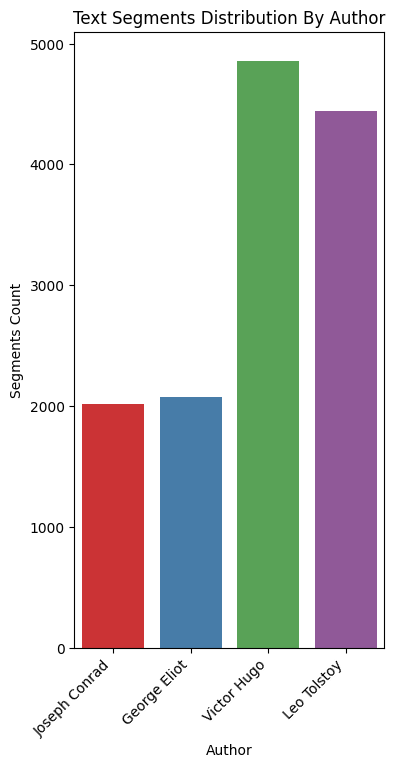

In [16]:
academic_palette = sns.color_palette('Set1', n_colors=df['Author'].nunique())
plt.figure(figsize=(4, 8))
sns.barplot(x='Author', y='SegmentCount', data=authors, palette=academic_palette)
plt.title('Text Segments Distribution By Author')
plt.xlabel('Author')  
plt.ylabel('Segments Count')
plt.xticks(rotation=45, ha='right')
plt.savefig(f'{plots_dir}segments_distribution_across_authors_TabNet_4.pdf', bbox_inches='tight')
plt.show()

In [17]:
X = df[x_columns]
y = df[y_column]

In [18]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [19]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

In [20]:
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [21]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [22]:
clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":10, "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax')

In [23]:
clf.fit(
  X_train, y_train,
  eval_set=[(X_val, y_val)],
  eval_name=['test'],
  eval_metric=['accuracy', 'logloss'],
  max_epochs=100,
  patience=3,
  batch_size=256,
  virtual_batch_size=128,
  num_workers=0,
  drop_last=False
)

epoch 0  | loss: 1.20538 | test_accuracy: 0.5508  | test_logloss: 1.02089 |  0:00:01s
epoch 1  | loss: 0.90336 | test_accuracy: 0.68177 | test_logloss: 0.79639 |  0:00:02s
epoch 2  | loss: 0.77545 | test_accuracy: 0.69422 | test_logloss: 0.74948 |  0:00:03s
epoch 3  | loss: 0.71064 | test_accuracy: 0.71564 | test_logloss: 0.71669 |  0:00:05s
epoch 4  | loss: 0.68079 | test_accuracy: 0.74104 | test_logloss: 0.66912 |  0:00:06s
epoch 5  | loss: 0.6695  | test_accuracy: 0.73556 | test_logloss: 0.67681 |  0:00:07s
epoch 6  | loss: 0.64644 | test_accuracy: 0.74751 | test_logloss: 0.64589 |  0:00:08s
epoch 7  | loss: 0.62335 | test_accuracy: 0.73157 | test_logloss: 0.68208 |  0:00:10s
epoch 8  | loss: 0.62862 | test_accuracy: 0.74104 | test_logloss: 0.6622  |  0:00:11s
epoch 9  | loss: 0.60873 | test_accuracy: 0.7495  | test_logloss: 0.61596 |  0:00:12s
epoch 10 | loss: 0.60925 | test_accuracy: 0.74701 | test_logloss: 0.63205 |  0:00:13s
epoch 11 | loss: 0.59578 | test_accuracy: 0.75498 | te

In [24]:
y_pred = clf.predict(X_test)

In [25]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

In [26]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7375498007968128
Precision: 0.7425827976091993
Recall: 0.7375498007968128
F1 Score: 0.7358376172557587


In [27]:
metrics_data = {'Accuracy': [accuracy], 'Precision': [precision], 'F1-Score': [f1], 'Recall': [recall]}

In [28]:
metrics_df = pd.DataFrame(metrics_data)

In [29]:
metrics_df

,Accuracy,Precision,F1-Score,Recall
0,0.73755,0.742583,0.735838,0.73755


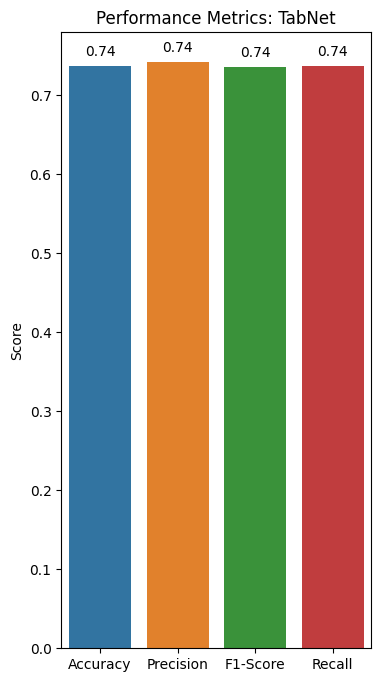

In [30]:
plt.figure(figsize=(4, 8))
ax = sns.barplot(data=metrics_df)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),  
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha = 'center',  
                va = 'center',  
                xytext = (0, 10),  
                textcoords = 'offset points')
plt.title('Performance Metrics: TabNet')
plt.ylabel('Score')
plt.savefig(f'{plots_dir}performance_TabNet_4.pdf', bbox_inches='tight')
plt.show()

In [31]:
y_prob = clf.predict_proba(X_test)
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_prob.shape[1]

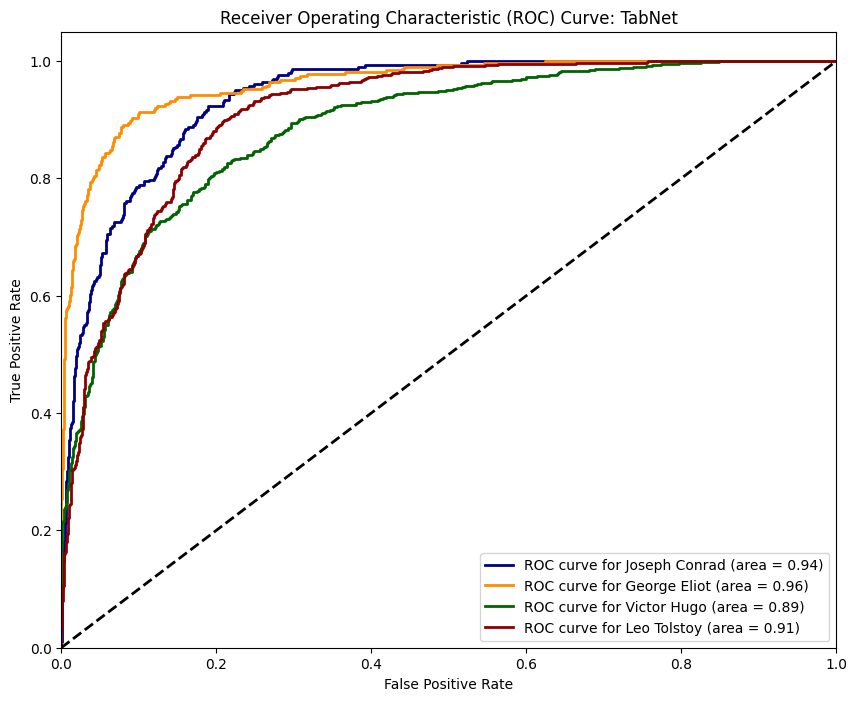

In [32]:
author_map = dict(zip(authors['AuthorCode'], authors['Author']))
n_classes = len(label_encoder.classes_)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['navy', 'darkorange', 'darkgreen', 'darkred'])

plt.figure(figsize=(10, 8))

for i, color in zip(range(n_classes), colors):
    label = author_map.get(i, f'Class {i}')
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {label} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve: TabNet')
plt.legend(loc="lower right")
plt.savefig(f'{plots_dir}roc_TabNet_4.pdf', bbox_inches='tight')
plt.show()

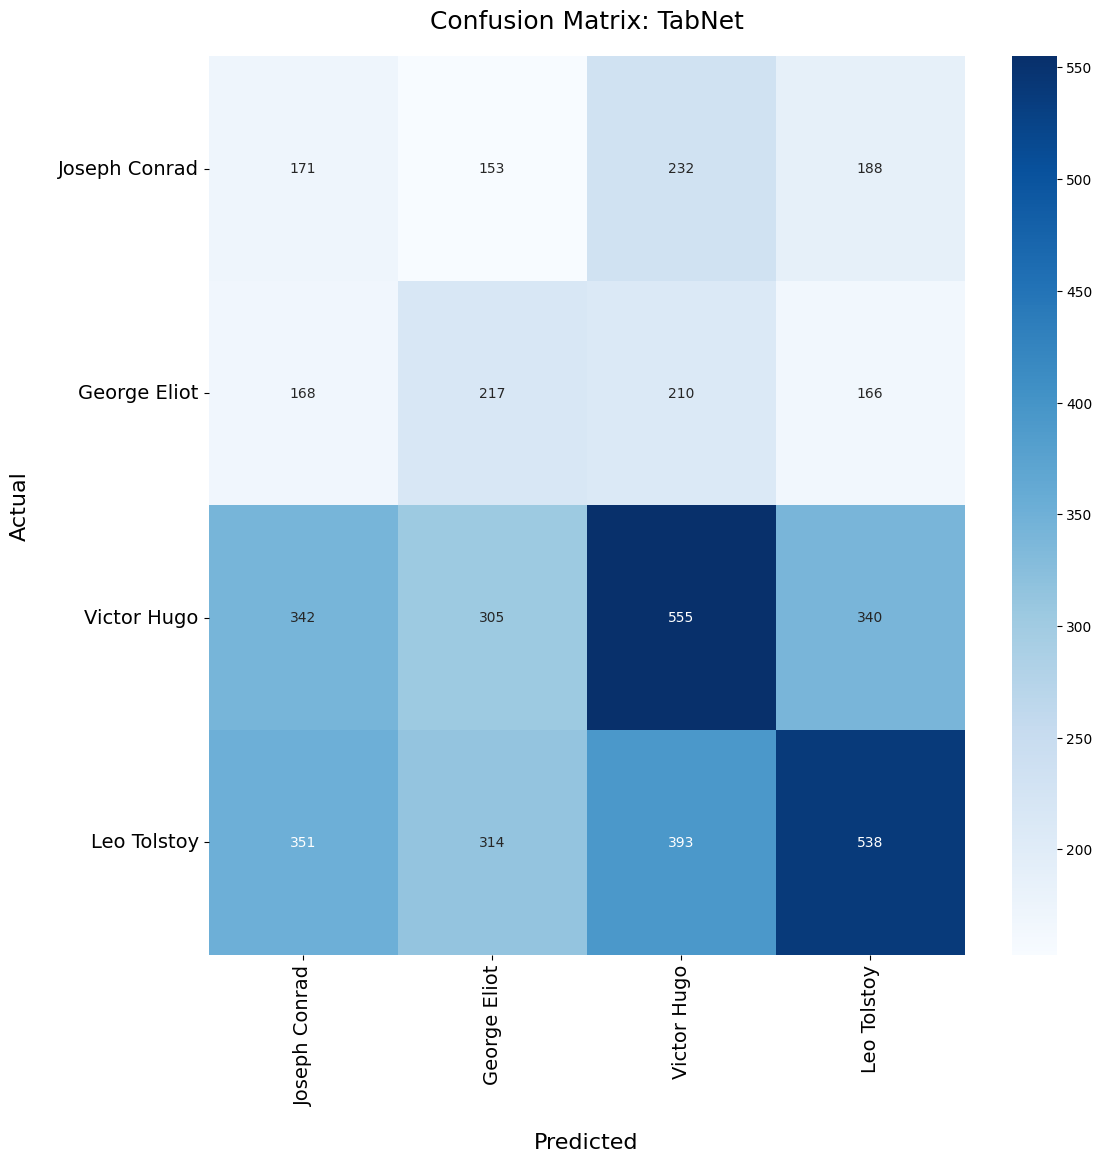

In [33]:
mcm = multilabel_confusion_matrix(y_test, y_pred)


total_labels = mcm.shape[0]
conf_matrix = np.zeros((total_labels, total_labels), dtype=int)

for label_index in range(total_labels):
    tn, fp, fn, tp = mcm[label_index].ravel()
    conf_matrix[label_index, label_index] = tp
    for i in range(total_labels):
        if i != label_index:

            fn_other, fp_other = mcm[i, 1, 0], mcm[i, 0, 1]
            conf_matrix[label_index, i] += fn_other
            conf_matrix[i, label_index] += fp_other


label_to_author = dict(zip(authors['AuthorCode'], authors['Author']))
author_names = [label_to_author.get(i, f'Label: {i}') for i in range(total_labels)]


plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=author_names, yticklabels=author_names)


plt.xlabel('Predicted', labelpad=20, fontsize=16)
plt.ylabel('Actual', labelpad=20, fontsize=16)
plt.title('Confusion Matrix: TabNet', pad=20, fontsize=18)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.tight_layout()
plt.subplots_adjust(left=0.2, bottom=0.2)  


plt.savefig(f'{plots_dir}cm_16_all2.pdf', bbox_inches='tight')
plt.show()

In [34]:
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print('Precision: ', precision)

Accuracy: 0.7375498007968128
Recall: 0.7375498007968128
F1 Score: 0.7358376172557587
Precision:  0.7425827976091993


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

In [36]:
epochs = list(range(16))

losses = [
    1.20538, 0.90336, 0.77545, 0.71064, 0.68079, 0.6695,
    0.64644, 0.62335, 0.62862, 0.60873, 0.60925, 0.59578,
    0.59028, 0.57667, 0.56983, 0.58279
]


test_accuracies = [
    0.5508, 0.68177, 0.69422, 0.71564, 0.74104, 0.73556,
    0.74751, 0.73157, 0.74104, 0.7495, 0.74701, 0.75498,
    0.75797, 0.75747, 0.75797, 0.74651
]

best_epoch = 12
best_test_accuracy = 0.75797

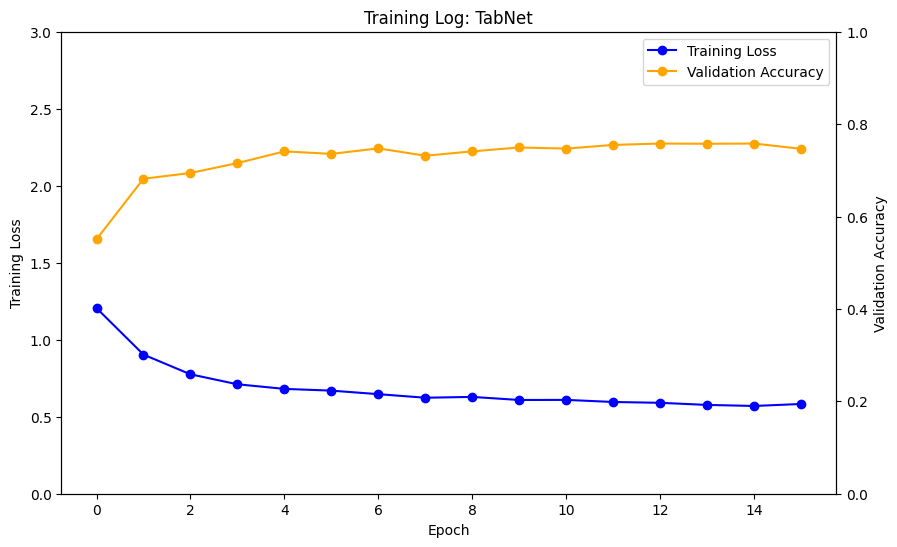

In [37]:
plt.figure(figsize=(10, 6))
ax1 = plt.gca()  
ax1.plot(epochs, losses, label='Training Loss', marker='o', color='blue')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss')
ax1.set_ylim(0, 3)  
ax1.grid(False)

ax2 = ax1.twinx()
ax2.plot(epochs, test_accuracies, label='Validation Accuracy', marker='o', color='orange')
ax2.set_ylabel('Validation Accuracy')
ax2.set_ylim(0, 1)  

# Combine the legends from both axes into one
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper right')

plt.title('Training Log: TabNet')

plt.savefig(f'{plots_dir}_tab_log_4.pdf', bbox_inches='tight')
plt.show()

In [38]:
results_df = pd.DataFrame({'Epoch': epochs, 'Loss': losses, 'Test Accuracy': test_accuracies})

In [41]:
epochs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

loss = [1.20538, 0.90336, 0.77545, 0.71064, 0.68079, 0.6695, 0.64644, 0.62335, 0.62862, 0.60873, 0.60925, 0.59578, 0.59028, 0.57667, 0.56983, 0.58279]

test_accuracy = [0.5508, 0.68177, 0.69422, 0.71564, 0.74104, 0.73556, 0.74751, 0.73157, 0.74104, 0.7495, 0.74701, 0.75498, 0.75797, 0.75747, 0.75797, 0.74651]

test_logloss = [1.02089, 0.79639, 0.74948, 0.71669, 0.66912, 0.67681, 0.64589, 0.68208, 0.6622, 0.61596, 0.63205, 0.6098, 0.59316, 0.61246, 0.61046, 0.63954]

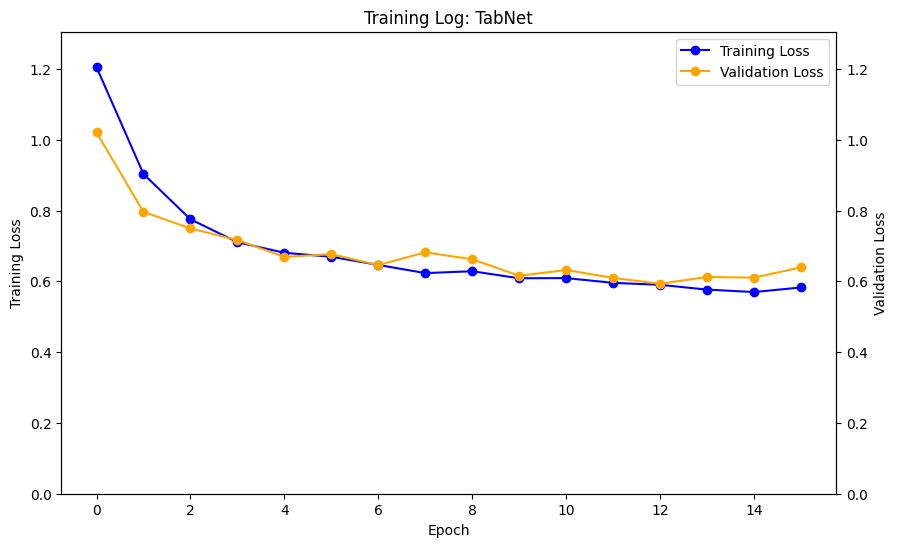

In [42]:
plt.figure(figsize=(10, 6))
ax1 = plt.gca()
ax1.plot(epochs, loss, label='Training Loss', marker='o', color='blue')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss')
ax1.grid(False)

ax2 = ax1.twinx()
ax2.plot(epochs, test_logloss, label='Validation Loss', marker='o', color='orange')
ax2.set_ylabel('Validation Loss')

# Set the same scale for both y-axes, starting from 0
common_max = max(max(loss), max(multi_log_loss))
ax1.set_ylim(0, common_max + 0.1)
ax2.set_ylim(0, common_max+ 0.1)

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper right')

plt.title('Training Log: TabNet')
plt.savefig('log_tab_4.pdf', bbox_inches='tight')

plt.show()

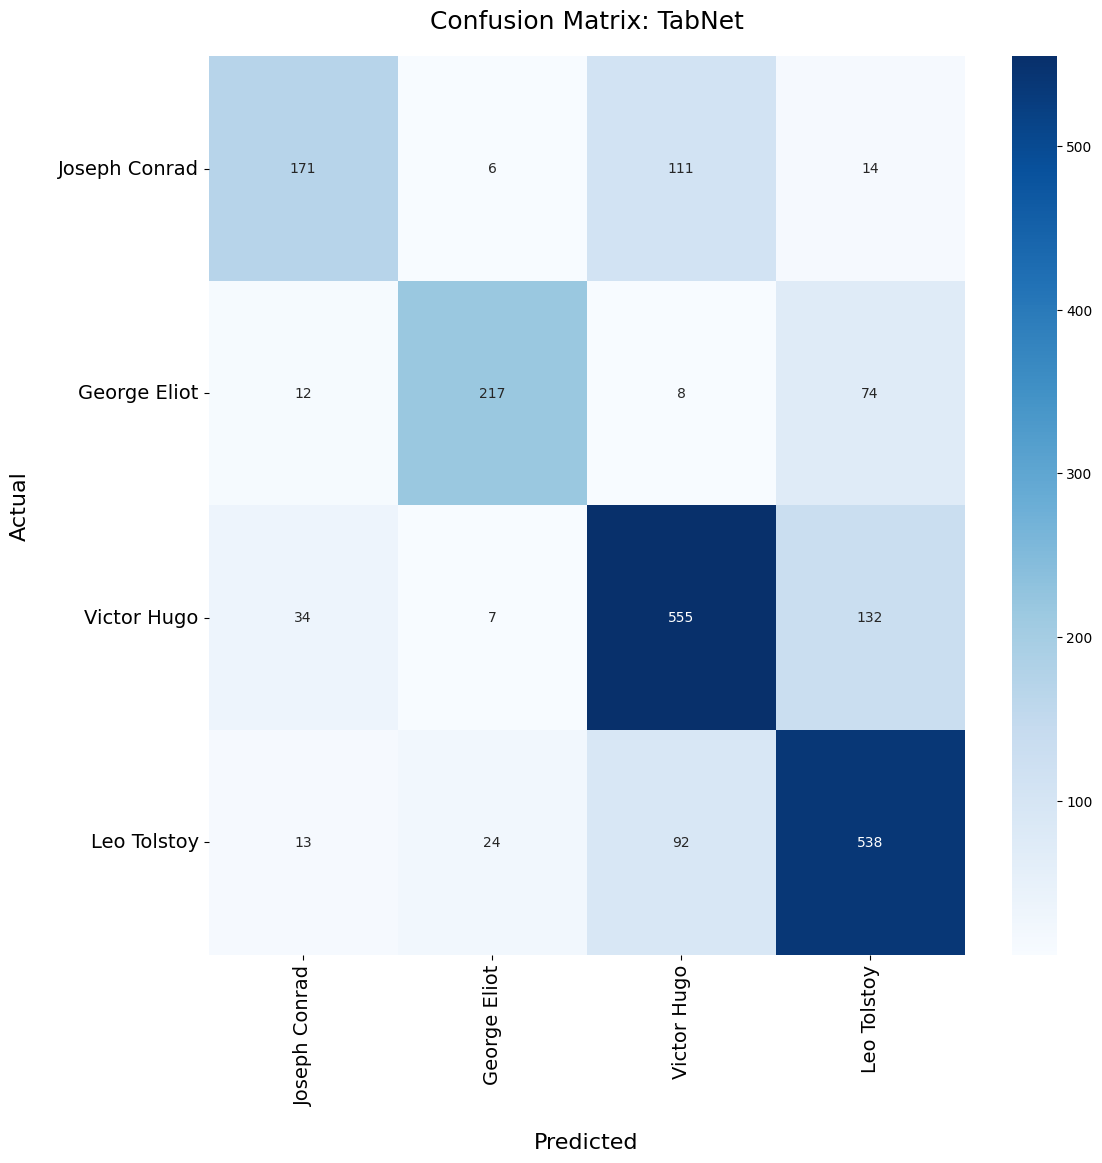

In [44]:
cm = confusion_matrix(y_test, y_pred)

# Assuming authors is a dictionary mapping author codes to author names
authors = {
    0: 'Joseph Conrad',
    1: 'George Eliot',
    2: 'Victor Hugo',
    3: 'Leo Tolstoy',
}

# Extract author names in the order of their codes
author_names = [authors.get(i, f'Label: {i}') for i in range(len(authors))]

plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=author_names, yticklabels=author_names)

plt.xlabel('Predicted', labelpad=20, fontsize=16)
plt.ylabel('Actual', labelpad=20, fontsize=16)
plt.title('Confusion Matrix: TabNet', pad=20, fontsize=18)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.tight_layout()
plt.subplots_adjust(left=0.2, bottom=0.2)

plt.savefig(f'{plots_dir}cm_16_all2.pdf', bbox_inches='tight')
plt.show()